# Building Insulation

The decision on much it invest in insulating a building is determined by a tradeoff between the capital costs of insulation and the annual operating costs for heating and air conditioning. This notebook shows the formulation and solution of an optimization problem using conic programming.


## A Model for Multi-Layered Insulation

Consider a wall or surface separating conditioned interior space in a building at temperature $T_i$ from the external environment at temperature $T_o$. Heat conduction through the wall is given by

$$\dot{Q} = UA (T_i - T_o)$$

where $U$ is the overall heat transfer coefficient. For a wall constructed from $N$ layers of different insulating materials, the inverse of the overall heat transfer coefficient is given by a sum of serial thermal "resistances"

$$\frac{1}{U} = R_0 + \sum_{n=1}^N R_n$$

where $R_0$ is thermal resistance of the structural elements. The thermal resistances of each insulating layer is given by $R_n = \frac{x_n}{k_n}$ for a material with thickness $x_n$ and a thermal conductivity $k_n$.

$$\frac{1}{U} = R_0 + \sum_{n=1}^N \frac{x_n}{k_n}$$

We assume the annual energy costs are proportional to thermal conductivity $U$. The cost of installing a unit area of unit area of insulation is given by an affine expression

$$a_n + b_n x_m$$

The combined annualized costs are then

$$C = \alpha U + \beta\sum_{n=1}^N (a_n y_n + b_n x_n)$$

where $\beta$ is a discount factor for the equivalent annualized cost of insulation, and binary variable $y_n$ is a binary variable indicates whether or not layer $n$ is included in the installation. The feasible values for $x_n$ are subject to constraints

$$\begin{align}
x_n & \leq Ty_n \\
\sum_{n=1}^N x_n & \leq T
\end{align}$$

where $T$ is an upper bound on insulation thickness.


## Single Layer Solutions

### Analytic Solution

The case $N=1$ has a simple analytical solution

$$\begin{align}
C^{min} = \min & \left(\frac{\alpha k}{k R_0 + x} + \beta(a + bx)\right)
\end{align}$$

Solving for the optimum thickness $x^{opt}$

$$x^{opt} = - k R_0 + \sqrt{\frac{\alpha k}{\beta b}} $$

A plot illustrates the trade off between operating and capital costs.


In [1]:
# application parameters
alpha = 30        # $ K / W annualized cost per sq meter per W/sq m/K
beta = 0.05       # equivalent annual cost factor
R0 = 2.0          # Watts/K/m**2
T = 0.30          # maximum insulation thickness

# material properties
k = 0.030         # thermal conductivity as installed
a = 5.0           # installation cost per square meter
b = 150.0         # installed material cost per cubic meter

cost = 4.99615 per sq. meter
xopt = 0.28641 meters


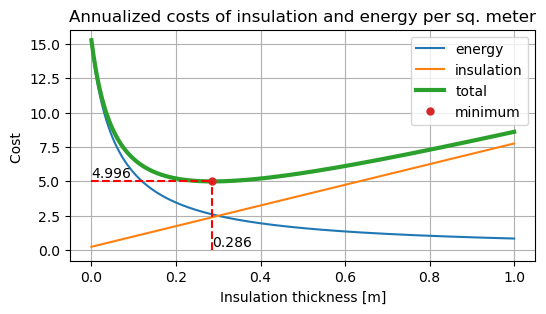

In [2]:
import matplotlib.pyplot as plt
import numpy as np

f = lambda x: alpha/(R0 + x/k)
g = lambda x: beta*(a + b*x)

# solution
xopt =  -k*R0 + np.sqrt(alpha*k/beta/b)

print(f"cost = {f(xopt) + g(xopt):0.5f} per sq. meter")
print(f"xopt = {xopt:0.5f} meters")

# plotting
x = np.linspace(0, 1, 201)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(x, f(x), label="energy")
ax.plot(x, g(x), label="insulation")
ax.plot(x, f(x) + g(x), label="total", lw=3)
ax.plot(xopt, f(xopt) + g(xopt), '.', ms=10, label="minimum")
ax.legend()

ax.plot([0, xopt], [f(xopt) + g(xopt)]*2, 'r--')
ax.plot([xopt]*2, [0, f(xopt) + g(xopt)], 'r--')
ax.text(0, f(xopt) + g(xopt) + 0.3, f"{f(xopt) + g(xopt):0.3f}")
ax.text(xopt, 0.3, f"{xopt:0.3f}")

ax.set_xlabel("Insulation thickness [m]")
ax.set_ylabel("Cost ")
ax.set_title("Annualized costs of insulation and energy per sq. meter")

ax.grid(True)

### Pyomo Model

$$\begin{align}
\min\ \alpha U + \beta(a + bx)
\end{align}$$

subject to

$$\begin{align}
R & = R_0 + \frac{x}{k} \\
z^2 & \leq 2 R U \\
z & = \sqrt{2} \\
x, R, U & \geq 0
\end{align}$$


In [3]:
import pyomo.kernel as pmo

m = pmo.block()

# decision variables
m.R = pmo.variable(lb=0)
m.U = pmo.variable(lb=0)
m.x = pmo.variable(lb=0)

# objective
m.cost = pmo.objective(alpha*m.U + beta*(a + b*m.x))

# insulation model
m.insulation = pmo.constraint(m.R == R0 + m.x/k)

# thickness constraint
m.thickness = pmo.constraint(m.x <= T)

# conic constraint
m.q = pmo.conic.rotated_quadratic.as_domain(m.R, m.U, [np.sqrt(2)])

# solve with 'mosek_direct' or 'gurobi_direct'
pmo.SolverFactory('mosek_direct').solve(m)

print(f"cost = {m.cost():0.5f} per sq. meter")
print(f"xopt = {m.x():0.5f} meters")

cost = 4.99615 per sq. meter
xopt = 0.28640 meters


## Multi-Layer Solutions as a Mixed Integer Quadratic Constraint Program (MIQCP)

The economic objective is to minimize the combined annual energy operating expenses and capital cost of insulation. Let $\alpha$ be a coefficient for the proportional relationship of the overall heat transfer coefficient $U$ to the annual energy costs.  

$$\min \alpha U + \beta \sum_{n=1}^N (a_ny_n + b_nx_n) $$

subject to constraints

$$
\begin{align}
R & = R_0 + \sum_{n=1}^N\frac{x_n}{k_n} \\
\sum_{n=1}^N x_n & \leq T \\
x_n & \geq 0 \\
y_n & \in \text{Binary} \\
x_n & \leq Ty_n \\
z^2 & \leq 2 R U \\
z & = \sqrt{2} \\
R, U & > 0
\end{align}
$$

where binary variables $y_n$ indicate whether layer $n$ is included in the insulation package, and $x_n$ is the thickness of layer $n$ if included.

### Sample Data

| Material | k (W/mK) | a | b |
| :-- | :--:| :--: | :--: |
| Mineral Wool | 0.030 | 5.0 | 150.0
| Rigid Foam (high R) | 0.022 | 8.0 | 180.0 
| Rigid Foam (low R) | 0.028 | 8.0 | 150.0

In [4]:
import pandas as pd

# application parameters
alpha = 30        # $ K / W annualized cost per sq meter per W/sq m/K
beta = 0.05       # equivalent annual cost factor
R0 = 2.0          # Watts/K/m**2
T = 0.30          # maximum insulation thickness

df = pd.DataFrame({
    "Mineral Wool": {"k": 0.030, "a": 5.0, "b": 150.0},
    "Rigid Foam (high R)": {"k": 0.015, "a": 8.0, "b": 180.0},
    "Rigid Foam (low R)": {"k": 0.3, "a": 8.0, "b": 120.0}
}).T

display(df)

,k,a,b
Mineral Wool,0.030,5.0,150.0
Rigid Foam (high R),0.015,8.0,180.0
Rigid Foam (low R),0.300,8.0,120.0


### Pyomo Model

In [5]:
import pyomo.kernel as pmo

m = pmo.block()

# parameters
m.N = df.index
m.a = pmo.parameter_dict()
m.b = pmo.parameter_dict()
m.k = pmo.parameter_dict()
for n in m.N:
    m.a[n] = pmo.parameter(df.loc[n, "a"])
    m.b[n] = pmo.parameter(df.loc[n, "b"])
    m.k[n] = pmo.parameter(df.loc[n, "k"])

# decision variables
m.R = pmo.variable(lb=0)
m.U = pmo.variable(lb=0)

m.x = pmo.variable_dict()
m.y = pmo.variable_dict()
for n in m.N:
    m.x[n] = pmo.variable(lb=0)
    m.y[n] = pmo.variable(domain=pmo.Binary)
    
# objective
m.cost = pmo.objective(alpha*m.U + beta*sum(m.a[n]*m.y[n] + m.b[n]*m.x[n] for n in m.N))

# insulation model
m.insulation = pmo.constraint(m.R == R0 + sum(m.x[n]/m.k[n] for n in m.N))

# thickness limit
m.thickness = pmo.constraint(sum(m.x[n] for n in m.N) <= T)

# layer model
m.layers = pmo.constraint_dict()
for n in m.N:
    m.layers[n] = pmo.constraint(m.x[n] <= T * m.y[n])
    
# conic constraint
m.q = pmo.conic.rotated_quadratic.as_domain(m.R, m.U, [np.sqrt(2)])

# solve with 'mosek_direct' or 'gurobi_direct'
solver = pmo.SolverFactory('mosek_direct')
solver.solve(m)

print(f"cost = {m.cost():0.5f} per sq. meter")
for n in m.N:
    print(f"x[{n}] = {m.x[n]():0.3f} meters")

cost = 4.15492 per sq. meter
x[Mineral Wool] = 0.000 meters
x[Rigid Foam (high R)] = 0.194 meters
x[Rigid Foam (low R)] = 0.000 meters


## Bibliographic Notes

To the best of my knowledge, this problem is not well-known example in the mathematical optimization literature. There are a number of application papers with differing levels of detail. 

> Hasan, A. (1999). Optimizing insulation thickness for buildings using life cycle cost. Applied energy, 63(2), 115-124. https://www.sciencedirect.com/science/article/pii/S0306261999000239

> Kaynakli, O. (2012). A review of the economical and optimum thermal insulation thickness for building applications. Renewable and Sustainable Energy Reviews, 16(1), 415-425. https://www.sciencedirect.com/science/article/pii/S1364032111004163

> Nyers, J., Kajtar, L., Tomić, S., & Nyers, A. (2015). Investment-savings method for energy-economic optimization of external wall thermal insulation thickness. Energy and Buildings, 86, 268-274.  https://www.sciencedirect.com/science/article/pii/S0378778814008688